# Demonstration notebook `deepSI_lite`

## Creating/obtaining train, val and test data in the form `Input_Output_data`

In [1]:
from deepSI_lite import Input_output_data
# from nonlinear_benchmarks import Input_output_data #equivilent as above
import numpy as np


#Example on how to create a Input_output_data
train = Input_output_data(u=np.array([1,2,3,4,5,1.,3]),y=np.array([1,-1,-3,10,11,12,13.]), sampling_time=1.0, name='my train set') 
test = Input_output_data(u=np.array([1,2,3,4,5,1.,3]),y=np.array([1,-1,-3,10,11,12,13.]), sampling_time=1.0, name='my test set') 
print(f'{train=}')
print(f'{test=}')

#getting a dataset
from nonlinear_benchmarks import Cascaded_Tanks
train, test = Cascaded_Tanks()
print(f'{train=}')
print(f'{test=}')

train=Input_output_data "my train set" u.shape=(7,) y.shape=(7,) sampling_time=1.0
test=Input_output_data "my test set" u.shape=(7,) y.shape=(7,) sampling_time=1.0
train=Input_output_data "train Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0
test=Input_output_data "test Cascaded_Tanks" u.shape=(1024,) y.shape=(1024,) sampling_time=4.0 state_initialization_window_length=5


## Creating a SUBNET structure 

Creating a model starts by characterizing by which kind of data it will be applied on. Example: number of inputs (`nu=3` for 3 inputs) or scalar inputs `nu='scalar'`. Futhermore, it is also used to re-scale such to normalize and de-normalize the of `f`, `h` and `encoder` (see `The shap bits of deepSI_lite.ipynb` for details)

If you want to use zero-mean, std one normalization you can use `get_nu_ny_and_auto_norm` to characterize what kind of data you are working with.

This can be used to initilize the SUBNET method (https://arxiv.org/abs/2012.07697, https://www.sciencedirect.com/science/article/pii/S0005109823003710) as seen below.

In [2]:
from deepSI_lite import SUBNET, get_nu_ny_and_auto_norm
import torch

nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
model = SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na)
# this model has four components:
# print(model.f)
# print(model.h)
# print(model.encoder)

r = lambda *x: torch.randn(*x)
x = r(1,model.nx)
u = r(1)
print(f'{model.f(x, u) = }') #the components can be evaluated in desired point

model.f(x, u) = tensor([[ 0.4299, -1.6303]], grad_fn=<AddBackward0>)


The SUBNET model has three components given by

$$
x_{k+1} = f_\theta(x_k, u_k)
$$
$$
\hat{y}_k = h_\theta(x_k)
$$
$$
x_0 = \psi_\theta(u_\text{past}, y_\text{past})
$$
where $\psi$ is the encoder that initializes the state.


## Fitting is a function in deepSI_lite

Fitting can be done with the following function:

```python
def fit(
    model: Any,
    train: Any,
    val: Any,
    n_its: int,
    T: int = 50,
    batch_size: int = 256,
    stride: int = 1,
    val_freq: int = 250,
    optimizer: Any = None,
    device: Any | None = None,
    compile_mode: Any | None = None,
    loss_fun: Any = compute_NMSE
) -> Any
```

where `T` is the trunctation lenght of the subsequences, `val_freq` is the frequency of which the validation loop will run.

You can also use `fit_minimal_implementation` which is a much smaller function but is missing some features.

In [3]:
from deepSI_lite.fitting import fit, fit_minimal_implementation
res = fit(model, train=train[:900], val=train[900:], n_its=1_001, T=30, batch_size=64, val_freq=100)


Number of samples to train on = 866


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.08931!! nan samps/sec
it     100 NRMS loss 0.72080 NRMS val 1.15769   985.28 samps/sec
it     200 NRMS loss 0.58555 NRMS val 0.78615!! 994.85 samps/sec
it     300 NRMS loss 0.53279 NRMS val 0.75488!! 998.23 samps/sec
it     400 NRMS loss 0.51718 NRMS val 0.74923!! 991.58 samps/sec
it     500 NRMS loss 0.52181 NRMS val 0.80550   982.81 samps/sec
it     600 NRMS loss 0.51831 NRMS val 0.86387   969.51 samps/sec
it     700 NRMS loss 0.51480 NRMS val 0.93010   958.71 samps/sec
it     800 NRMS loss 0.50600 NRMS val 0.97709   956.97 samps/sec
it     900 NRMS loss 0.48456 NRMS val 0.91428   959.60 samps/sec
it   1,000 NRMS loss 0.50948 NRMS val 0.96823   966.17 samps/sec


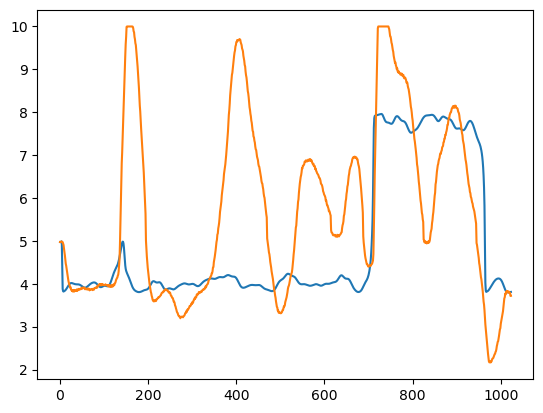

NRMS=101.90%
RMSE=2.1391 V


In [4]:
from matplotlib import pyplot as plt
plt.plot(model.simulate(test).y) #simulate is apply_experiment equivilent
plt.plot(test.y)
plt.show()
from nonlinear_benchmarks.error_metrics import NRMSE, RMSE
print(f'NRMS={NRMSE(test.y, model.simulate(test).y):.2%}')
print(f'RMSE={RMSE(test.y, model.simulate(test).y):.4f} V')

### Continous time SUBNET

In [8]:
from deepSI_lite.models import SUBNET_CT
from deepSI_lite.fitting import fit
from nonlinear_benchmarks import Cascaded_Tanks
from deepSI_lite.networks import euler_integrator, rk4_integrator, rk45_integrator
train, test = Cascaded_Tanks()

nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)
torch.manual_seed(0)
model_CT = SUBNET_CT(nu, ny, norm, nx=2, na=4, nb=4, integrator=euler_integrator)
train_dict = fit(model_CT, train, test, 1001, T=60, val_freq=20)

Number of samples to train on = 961


  0%|          | 0/1001 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 1.01385!! nan samps/sec
it      20 NRMS loss 0.61773 NRMS val 0.47273!! 3297.20 samps/sec
it      40 NRMS loss 0.36855 NRMS val 0.48453   3459.86 samps/sec
it      60 NRMS loss 0.33149 NRMS val 1.01785   3507.71 samps/sec
it      80 NRMS loss 0.29161 NRMS val 1.17273   3545.51 samps/sec
it     100 NRMS loss 0.25882 NRMS val 1.40911   3566.84 samps/sec
it     120 NRMS loss 0.24207 NRMS val 1.40752   3577.45 samps/sec
it     140 NRMS loss 0.23263 NRMS val 1.48823   3498.80 samps/sec
it     160 NRMS loss 0.22584 NRMS val 1.55652   3363.99 samps/sec
it     180 NRMS loss 0.21659 NRMS val 1.61769   3299.35 samps/sec
it     200 NRMS loss 0.21098 NRMS val 1.65873   3247.16 samps/sec
it     220 NRMS loss 0.20767 NRMS val 1.69023   3206.91 samps/sec
it     240 NRMS loss 0.20223 NRMS val 1.70139   3168.46 samps/sec
it     260 NRMS loss 0.19833 NRMS val 1.71365   3145.27 samps/sec
it     280 NRMS loss 0.19340 NRMS val 1.74223   3122.62 samps/sec
it     300 NRMS lo

### Changing the intergator

In [5]:
from deepSI_lite.networks import euler_integrator, rk4_integrator, rk45_integrator
integrator = rk4_integrator
n_steps = 3
model_CT.integrator = lambda f,x,u,dt: integrator(f,x,u,dt, n_steps) 
print(f'RMSE={RMSE(test.y, model_CT.simulate(test).y):.4f} V')

NameError: name 'model_CT' is not defined

## cutomizable SUBNET

If you want to parameterize differently (number of layers and different functions) than you can pass your desired f, h and encoder into the SUBNET structure class.  

In [ ]:
from deepSI_lite.networks import MLP_res_net
from torch import nn
from deepSI_lite.models import SUBNET
from deepSI_lite import get_nu_ny_and_auto_norm
from nonlinear_benchmarks import Cascaded_Tanks
train, test = Cascaded_Tanks()
nx, nb, na = 2, 5, 5
nu, ny, norm = get_nu_ny_and_auto_norm(train)

f = norm.f(MLP_res_net(input_size = [nx , nu], output_size = nx, activation=nn.Sigmoid))
h = norm.h(MLP_res_net(input_size = nx, output_size = ny, n_hidden_layers=5, n_hidden_nodes=10))
encoder = norm.encoder(MLP_res_net(input_size = [(nb,nu) , (na,ny)], output_size = nx, n_hidden_layers=1, n_hidden_nodes=15))

print(f) #has f(x,u) -> x with batch
print(h) #has h(x,u) -> y with batch if feedthrough = True else h(x) -> y
print(encoder) #has encoder(upast, ypast) -> x

print(SUBNET(nu, ny, norm, nx=nx, nb=nb, na=na, f=f, h=h, encoder=encoder))

## Creating a fully cutomizable SUBNET structure

A limitation in the `SUBNET` class is that the f, h and the encoder does not share any parameters. If this is not the case than you create you own cutom SUBNET structure. Below you can find an example for a LPV structure, see: https://arxiv.org/abs/2204.04060

In [22]:
from deepSI_lite.models import Custom_SUBNET
from deepSI_lite import Norm
from deepSI_lite.networks import Bilinear
class SUBNET_LPV(Custom_SUBNET):
    def __init__(self, nu, ny, norm:Norm, nx, n_schedual, na, nb, scheduling_net=None, A=None, B=None, C=None, D=None, encoder=None, feedthrough=True):
        if np.any(10*abs(norm.y0)>norm.ystd) or np.any(10*abs(norm.umean)>norm.ustd):
            from warnings import warn
            warn('SUBNET_LPV assumes that the data is approximatly zero mean. Not doing so can lead to unintended behaviour.')
        assert isinstance(nu, int) and isinstance(ny, int) and isinstance(n_schedual, int) and feedthrough, 'SUBNET_LPV requires the input, output schedualing parameter to be vectors and feedthrough to be present'
        super().__init__()
        self.nu, self.ny, self.norm, self.nx, self.np, self.na, self.nb, self.feedthrough = nu, ny, norm, nx, n_schedual, na, nb, feedthrough
        self.A = A if A is not None else Bilinear(n_in=nx, n_out=nx, n_schedual=n_schedual)
        self.B = B if B is not None else Bilinear(n_in=nu, n_out=nx, n_schedual=n_schedual, std_input=norm.ustd)
        self.C = C if C is not None else Bilinear(n_in=nx, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd)
        self.D = D if D is not None else Bilinear(n_in=nu, n_out=ny, n_schedual=n_schedual, std_output=norm.ystd, std_input=norm.ustd)
        self.encoder = encoder if encoder is not None else norm.encoder(MLP_res_net(input_size = [(nb,nu) , (na,ny)], output_size = nx))
        self.scheduling_net = scheduling_net if scheduling_net is not None else norm.f(MLP_res_net(input_size = [nx , nu], output_size = n_schedual))
        validate_custom_SUBNET_structure(self) #does checks if forward is working as intended
    
    def forward(self, upast: torch.Tensor, ypast: torch.Tensor, ufuture: torch.Tensor, yfuture: torch.Tensor=None):
        mv = lambda A, x: torch.bmm(A, x[:, :, None])[:,:,0] #batched matrix vector multiply
        yfuture_sim = []
        x = self.encoder(upast, ypast)
        for u in ufuture.swapaxes(0,1): #iterate over time
            p = self.scheduling_net(x, u)
            A, B, C, D = self.A(p), self.B(p), self.C(p), self.D(p)
            y = mv(C, x) + mv(D, u)
            x = mv(A, x) + mv(B, u)
            yfuture_sim.append(y)
        return torch.stack(yfuture_sim, dim=1)


## Exporting functions

This can for since be loaded in https://netron.app/ to see the computation graph

or with MATLAB

or even CasaDI with some effort.

In [ ]:
import torch
from torch import nn
class Fun(nn.Module):
    def __init__(self, f, model):
        super().__init__()
        self.f = f
        self.model = model
    def forward(self, *args, **kwargs):
        with torch.no_grad():
            return self.f(*args, **kwargs)

f = Fun(model.f, model)
x = torch.zeros((1it works????
u = torch.zeros((1,1))[0] if model.nu == 'scalar' else torch.zeros((1,model.nu))

torch.onnx.export(
    f,                  # the model (in this case Fun class wrapping your model)
    (x, u),             # input tensors (in this case x and u)
    "ONNX_export/f.onnx",       # file name or file path where the model will be saved
    opset_version=12    # specify the ONNX opset version
)



## Reproducability

In [6]:
from deepSI_lite.models import SUBNET_LPV, SUBNET, SUBNET_CT
from deepSI_lite.normalization import Norm, get_nu_ny_and_auto_norm
from deepSI_lite.fitting import fit, compute_clamp_NMSE
from nonlinear_benchmarks import Silverbox
import numpy as np
import torch

train_val, tests = Silverbox()
test = tests[0]
s = int(0.95*len(train_val))
train, val = train_val[:s], train_val[s:]
nu, ny, norm = get_nu_ny_and_auto_norm(train_val)

for _ in range(2):
    torch.manual_seed(0)
    subnet = SUBNET(nu, ny, norm, nx=4, nb=20, na=20)
    fit_res_subnet = fit(subnet, train, val, n_its=100, val_freq=10)


Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 4835.67 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 4822.75 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 4535.20 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 4575.48 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 4611.22 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 4650.03 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 4621.68 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 4635.13 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 4631.28 samps/sec
Number of samples to train on = 61739


  0%|          | 0/100 [00:00<?, ?it/s]

it       0 NRMS loss nan NRMS val 0.99626!! nan samps/sec
it      10 NRMS loss 0.96911 NRMS val 0.91461!! 4814.58 samps/sec
it      20 NRMS loss 0.88075 NRMS val 0.87685!! 4797.26 samps/sec
it      30 NRMS loss 0.84420 NRMS val 0.84332!! 4594.71 samps/sec
it      40 NRMS loss 0.75531 NRMS val 0.58872!! 4647.70 samps/sec
it      50 NRMS loss 0.51822 NRMS val 0.54371!! 4682.50 samps/sec
it      60 NRMS loss 0.45830 NRMS val 0.49202!! 4685.92 samps/sec
it      70 NRMS loss 0.40896 NRMS val 0.41274!! 4694.99 samps/sec
it      80 NRMS loss 0.36910 NRMS val 0.36029!! 4683.94 samps/sec
it      90 NRMS loss 0.32021 NRMS val 0.31022!! 4628.09 samps/sec
